[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Priesemann-Group/covid19_inference/blob/model_cleanup/scripts/interactive/example_one_bundesland.ipynb)

In [13]:
!pip install git+https://github.com/Priesemann-Group/covid19_inference.git

  Cloning https://github.com/Priesemann-Group/covid19_inference.git to /tmp/pip-req-build-2z244o2f
  Running command git clone -q https://github.com/Priesemann-Group/covid19_inference.git /tmp/pip-req-build-2z244o2f
  Created wheel for covid19-inference: filename=covid19_inference-0.1.8a0-cp36-none-any.whl size=103637 sha256=07b282553da9a3a84d741f893c5f45e463351ab1c514e432f87c2345fa363d29
  Stored in directory: /tmp/pip-ephem-wheel-cache-rg4g4h5f/wheels/da/f1/e7/da56ba4fe019b70927b4bb10088f02f672b31b69fd54a6e613
Successfully built covid19-inference



<!-- 
1.   List item
2.   List item -->



# Bayesian Inference of Ghana Covid 19 Data
Non-hierarchical model using jhu data.

Runtime ~ 15 min

The first thing we need to do is import some essential stuff. Theses have to be installed and are prerequisites.


In [14]:
import datetime
import time as time_module
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import theano
import theano.tensor as tt
import pymc3 as pm

In [15]:
# Now to the fun stuff, we import our module!
try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19


## Data retrieval

The next thing we want to do is load a dataset from somewhere.
There are multiple download sources which can be found [here](https://covid19-inference.readthedocs.io/en/latest/doc/data_retrieval.html).
In this example we will use the RKI dataset.


In [16]:
# rki = cov19.data_retrieval.RKI()  # It is important to download the dataset!
# rki.download_all_available_data()
# # One could also parse True to the constructor of the class to force an auto download

In [17]:
### Use John Hopkins Database

In [18]:
jhu = cov19.data_retrieval.JHU()  # It is important to download the dataset!
jhu.download_all_available_data()
# One could also parse True to the constructor of the class to force an auto download

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local




We can now access this downloaded data by the attribute
```
rki.data
```
but normally one would use the build in filter methods,
these can be found [here](https://covid19-inference.readthedocs.io/en/latest/doc/data_retrieval.html#covid19_inference.data_retrieval.JHU.get_new).

Next we retrieve the filtered data from our source in this example we will get all new cases and the total (cumulative) cases for the bundesland "Sachsen".


Get total confirmed case for Ghana

In [19]:
bd = datetime.datetime(2020, 3, 14)  # For the date filter
ed = datetime.datetime.now() 

In [20]:
ghana_covid_record = jhu.get_total_confirmed_deaths_recovered(country='Ghana', begin_date= bd, end_date=ed)

Get new cases for Ghana

In [21]:
ghana_covid_new_cases = jhu.get_new(country = "Ghana", data_begin= bd, data_end=ed)

## Preprocess the data

In [25]:
ghana_covid_100_above_record = ghana_covid_record[ghana_covid_record.confirmed >=100]['confirmed']

In [26]:
ghana_covid_100_above_record

date
2020-03-26      132
2020-03-27      137
2020-03-28      141
2020-03-29      152
2020-03-30      152
              ...  
2020-08-01    37014
2020-08-02    37014
2020-08-03    37812
2020-08-04    37812
2020-08-05    39075
Name: confirmed, Length: 133, dtype: int64

In [27]:
ghana_covid_new_cases.head(5)

date
2020-03-14    3
2020-03-15    3
2020-03-16    0
2020-03-17    1
2020-03-18    0
Name: confirmed, dtype: int64

- Check for dates with NAN values in dates

<!-- > Indented block -->



In [28]:
ghana_covid_100_above_record.index.isnull().any()

False

In [29]:
ghana_covid_100_above_record.index.isnull().any()

False

There are no missing dates

## Split data into train and validate sets

> Train set



In [30]:
july_25 = ghana_covid_100_above_record[ghana_covid_100_above_record.index == "2020-07-25"].index[0]
start = ghana_covid_100_above_record.head(1).index[0]
train_ghana = ghana_covid_100_above_record.loc[start:july_25]
train_ghana

date
2020-03-26      132
2020-03-27      137
2020-03-28      141
2020-03-29      152
2020-03-30      152
              ...  
2020-07-21    28989
2020-07-22    29672
2020-07-23    29672
2020-07-24    31057
2020-07-25    31851
Name: confirmed, Length: 122, dtype: int64

> Validate Set

In [31]:
validate_ghana = ghana_covid_100_above_record.loc[july_25:]
validate_ghana

date
2020-07-25    31851
2020-07-26    32969
2020-07-27    33624
2020-07-28    34406
2020-07-29    35142
2020-07-30    35142
2020-07-31    35501
2020-08-01    37014
2020-08-02    37014
2020-08-03    37812
2020-08-04    37812
2020-08-05    39075
Name: confirmed, dtype: int64

### Plot training data

INFO     [numexpr.utils] NumExpr defaulting to 2 threads.


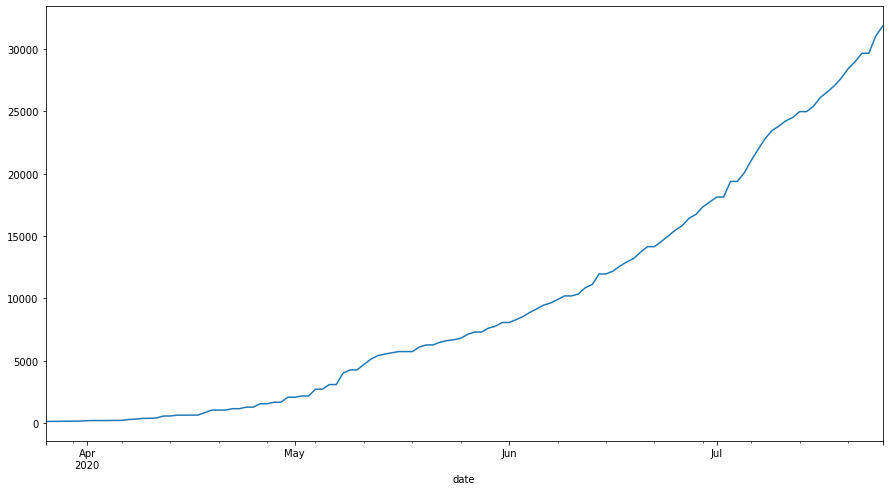

In [32]:
train_ghana.plot(figsize=(15,8));

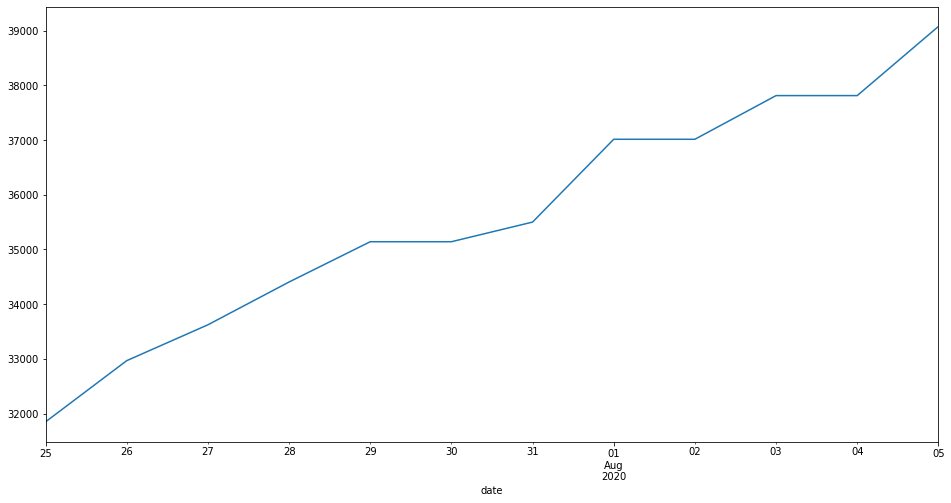

In [33]:
validate_ghana.plot(figsize=(16,8));



## Create the model

First we need to set the priors for the change points and other configs.


### Changepoints

 - Fisrst covid record
>> Begin Date(bd) - March 14, 2020

- prior data before mild social distancing began
>> Ban major Gatherings — March 15, 2020 

-  prior data before strong social distancing began
>>  Travel Restrictions — March 17 2020

- prior data before contact ban begin
>> Partial Lockdown — March 30, 2020-Second Model ( Task 2 g to j) Dates.

>>Mask Wearing Mandatory — June 15, 
2020

>>Relaxing the Previous Rules — July 26,  2020


In [34]:
diff_data_sim = 16  # should be significantly larger than the expected delay, in
# order to always fit the same number of data points.
num_days_forecast = 10

In [35]:
# We set the priors for the changepoints here
prior_date_mild_dist_begin = datetime.datetime(2020, 3, 15)
prior_date_strong_dist_begin = datetime.datetime(2020, 3, 17)
prior_date_contact_ban_begin = datetime.datetime(2020, 3, 30)

In [36]:
change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8 / 2,
        pr_sigma_lambda=1,
    ),
]



Next, we create the model! There are default values for most of the function arguments,
but we will try to explicitly set all kwargs for the sake of this example.


In [37]:
params_model = dict(
    new_cases_obs=ghana_covid_new_cases[:],
    data_begin=bd,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=4e6,
)
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10



The model is specified in a context. Each function in this context
has access to the model parameters set.


In [38]:
with cov19.model.Cov19Model(**params_model) as this_model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,  # The change point priors we constructed earlier
        name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )

    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference.
    # It is not necessary to use it, one can simply remove it and use the default argument
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log,
        mu=mu,
        pr_median_delay=pr_delay,
        name_I_begin="I_begin",
        name_I_begin_ratio_log="I_begin_ratio_log",
        pr_sigma_I_begin=2,
        n_data_points_used=5,
    )

    # Use lambda_t_log and mu to run the SIR model
    new_cases = cov19.model.SIR(
        lambda_t_log=lambda_t_log,
        mu=mu,
        name_new_I_t="new_I_t",
        name_I_t="I_t",
        name_I_begin="I_begin",
        pr_I_begin=prior_I,
    )

    # Delay the cases by a lognormal reporting delay
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        name_delay="delay",
        name_width="delay-width",
        pr_mean_of_median=pr_delay,
        pr_sigma_of_median=0.2,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(
        cases=new_cases,
        name_cases="new_cases",
        name_weekend_factor="weekend_factor",
        name_offset_modulation="offset_modulation",
        week_modulation_type="abs_sine",
        pr_mean_weekend_factor=0.3,
        pr_sigma_weekend_factor=0.5,
        weekend_days=(6, 7),
    )

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO  


## MCMC sampling

After the model is built, it is sampled using an MCMC sampler.
The number of parallel runs can be set with the argument `cores=`.
In particular, due to a bug in Theano, Windows users should set `cores=1`.
The sampling can take a long time.


In [1]:
trace = pm.sample(model=this_model, cores=4, tune=259, draws=500, init="advi+adapt_diag")

NameError: ignored


## Plotting
Plotting tools are rudimentary right now. But one can always write custom plotting function
by accessing the samples stored in the trace.

### Distributions


In [46]:
trace

<MultiTrace: 8 chains, 60 iterations, 36 variables>

Possible varnames are :
['lambda_0_log_', 'lambda_1_log_', 'lambda_2_log_', 'lambda_3_log_', 'transient_day_1', 'transient_day_2', 'transient_day_3', 'transient_len_1_log_', 'transient_len_2_log_', 'transient_len_3_log_', 'mu', 'I_begin_ratio_log', 'delay_log', 'weekend_factor_log', 'offset_modulation_rad_circular__', 'sigma_obs']


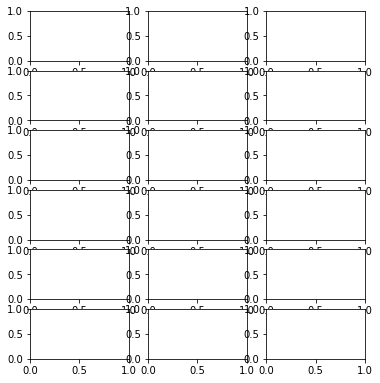

In [47]:
fig, axes = plt.subplots(6, 3, figsize=(6, 6.4))
varnames = this_model.untransformed_freeRVs
print("Possible varnames are :")
print(varnames)

In [48]:
for i, key in enumerate(
    # left column
    ["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2", "lambda_3"]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 0])

In [49]:
for i, key in enumerate(
    # mid column
    [
        "offset_modulation",
        "sigma_obs",
        "I_begin",
        "transient_day_1",
        "transient_day_2",
        "transient_day_3",
    ]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 1])

In [50]:
for i, key in enumerate(
    # right column
    ["delay", "transient_len_1", "transient_len_2", "transient_len_3",]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i + 2, 2])

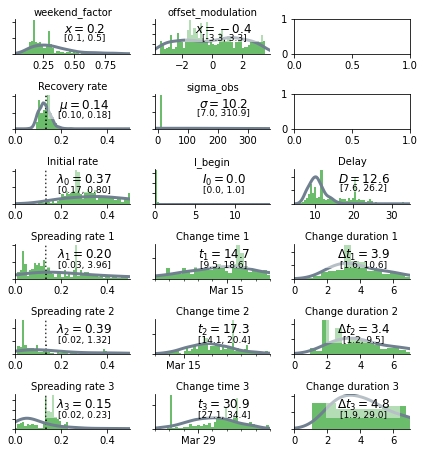

In [52]:
fig.tight_layout()
fig #To print in jupyter notebook


### Timeseries
timeseries overview, for now needs an offset variable to get cumulative cases


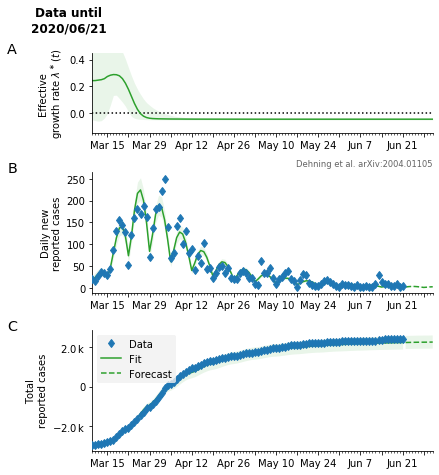

In [ ]:
fig, axes = cov19.plot.timeseries_overview(this_model, trace, offset=-3000)